## Sepración en validación y test

In [2]:

import pandas as pd

# Volver a cargar los CSV originales y aumentados
augmented_df = pd.read_csv("C:/Users/34629/TFG/augmented_TT_dataset_no_O.csv")
original_df = pd.read_csv("C:/Users/34629/TFG/single_label_dataset_without_H_no_O.csv")

# Identificar las clases disponibles
classes = ['N', 'D', 'G', 'C', 'A', 'M']

# Añadir una columna con la clase dominante
def get_class_label(row):
    for c in classes:
        if row[c] == 1:
            return c
    return None

# Aplicar a ambos datasets
augmented_df['class_label'] = augmented_df.apply(get_class_label, axis=1)
original_df['class_label'] = original_df.apply(get_class_label, axis=1)

# Identificar imágenes originales dentro del dataset aumentado
original_paths = set(original_df['Image_Path'])
augmented_df['is_original'] = augmented_df['Image_Path'].isin(original_paths)

# Seleccionar 10% por clase para validación (solo de imágenes originales)
val_df = (
    augmented_df[augmented_df['is_original']]
    .groupby('class_label', group_keys=False)
    .apply(lambda x: x.sample(frac=0.10, random_state=42))
)

# El resto será entrenamiento: originales restantes + aumentadas no originales
train_df = augmented_df[~augmented_df['Image_Path'].isin(val_df['Image_Path'])]

# Guardar CSVs resultantes
train_path = "C:/Users/34629/TFG/train_TT.csv"
val_path = "C:/Users/34629/TFG/val_TT.csv"
train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)

# Confirmar tamaños
train_df.shape, val_df.shape



C:\Users\34629\AppData\Local\Temp\ipykernel_16932\2355970858.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.10, random_state=42))


((12188, 15), (580, 15))

## Modelos


Epoch 1/80




c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


762/762 - 31s - loss: 1.4285 - accuracy: 0.3991 - f1: 0.3917 - val_loss: 1.1041 - val_accuracy: 0.5345 - val_f1: 0.4014 - 31s/epoch - 40ms/step
Epoch 2/80
762/762 - 16s - loss: 1.1201 - accuracy: 0.5108 - f1: 0.5037 - val_loss: 1.0939 - val_accuracy: 0.4897 - val_f1: 0.4524 - 16s/epoch - 21ms/step
Epoch 3/80
762/762 - 18s - loss: 1.0250 - accuracy: 0.5512 - f1: 0.5472 - val_loss: 1.0636 - val_accuracy: 0.4534 - val_f1: 0.4663 - 18s/epoch - 23ms/step
Epoch 4/80
762/762 - 17s - loss: 0.9836 - accuracy: 0.5681 - f1: 0.5645 - val_loss: 0.9896 - val_accuracy: 0.5259 - val_f1: 0.4579 - 17s/epoch - 22ms/step
Epoch 5/80
762/762 - 17s - loss: 0.9526 - accuracy: 0.5744 - f1: 0.5713 - val_loss: 0.9709 - val_accuracy: 0.5362 - val_f1: 0.4870 - 17s/epoch - 23ms/step
Epoch 6/80
762/762 - 17s - loss: 0.9300 - accuracy: 0.5838 - f1: 0.5818 - val_loss: 1.0153 - val_accuracy: 0.5276 - val_f1: 0.4923 - 17s/epoch - 22ms/step
Epoch 7/80
762/762 - 17s - loss: 0.9045 - accuracy: 0.6003 - f1: 0.5993 - val_los

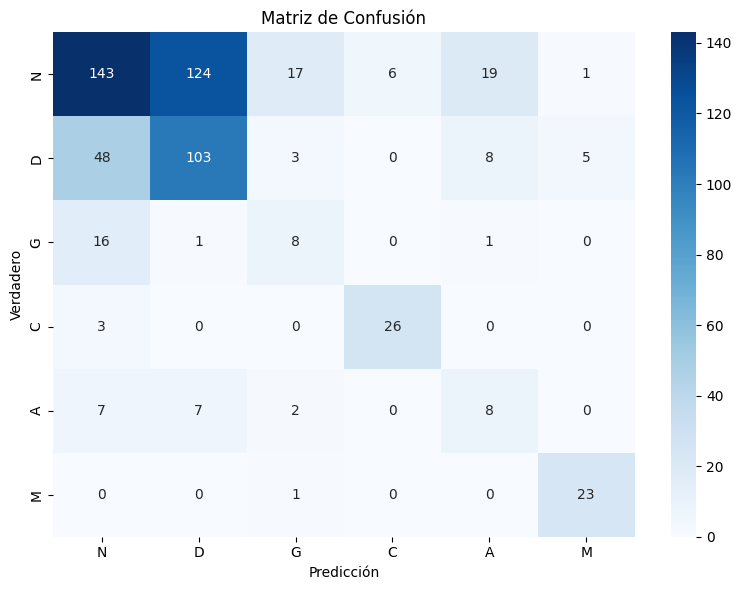

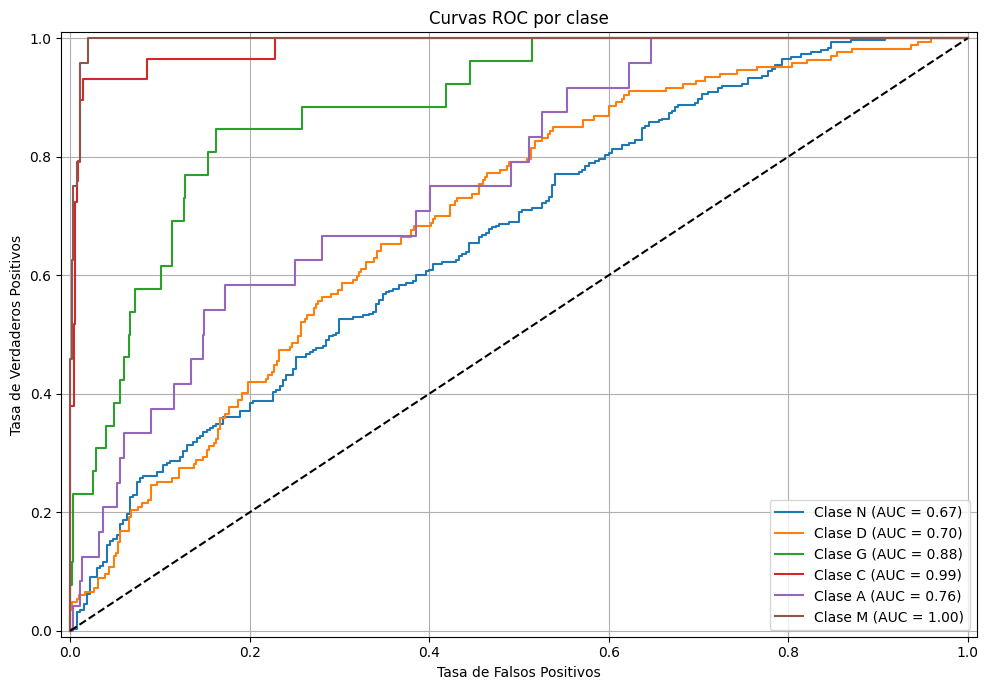

In [3]:
### MODELO 1 – USANDO SPLIT MANUAL TRAIN/VALID ###

import os
import sys
import numpy as np
import pandas as pd
import torch
import argparse
from tqdm import tqdm
import cv2

# 0) Ajustes iniciales
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABEL_MAP = {c:i for i,c in enumerate(['N','D','G','C','A','M'])}

sys.path.append(r"C:\Users\34629\Downloads\RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed
from sklearn.utils.class_weight import compute_class_weight

# allowlist argparse.Namespace
torch.serialization.add_safe_globals([argparse.Namespace])

# 1) Función para extraer características con RETFound
def extract_retfound_features(image_paths, weights_path):
    model = RETFound_mae(global_pool=True, img_size=IMG_SIZE)
    ckpt = torch.load(weights_path, map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False)
    model.eval()
    feats = []
    for p in tqdm(image_paths, desc="Extrayendo RETFound"):
        img = torch.from_numpy((cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE)) / 255.0).astype('float32')).permute(2,0,1).unsqueeze(0)
        with torch.no_grad():
            f = model.forward_features(img).cpu().numpy().squeeze()
        feats.append(f)
    return np.stack(feats)

# 2) Cargar CSVs manuales
train_df = pd.read_csv("C:/Users/34629/TFG/train_TT.csv")
val_df = pd.read_csv("C:/Users/34629/TFG/val_TT.csv")

train_df['label'] = train_df['class_label'].map(LABEL_MAP)
val_df['label'] = val_df['class_label'].map(LABEL_MAP)

train_paths = train_df['Image_Path'].tolist()
val_paths = val_df['Image_Path'].tolist()
train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

# 3) Cargar si existen, o extraer y guardar
# if os.path.exists("C:/Users/34629/Downloads/X_TT_train.npy") and os.path.exists("C:/Users/34629/Downloads/y_TT_train.npy") and os.path.exists("C:/Users/34629/Downloads/X_val.npy") and os.path.exists("C:/Users/34629/Downloads/y_val.npy"):
#     print("🔁 Cargando características RETFound desde disco...")
X_tr = np.load("C:/Users/34629/Downloads/X_TT_train.npy")
y_tr = np.load("C:/Users/34629/Downloads/y_TT_train.npy")
X_vl = np.load("C:/Users/34629/Downloads/X_TT_val.npy")
y_vl = np.load("C:/Users/34629/Downloads/y_TT_val.npy")
# else:
#     print("⚙️ Extrayendo características RETFound...")
#     X_tr = extract_retfound_features(train_paths, r"C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
#     y_tr = np.array(train_labels)
#     X_vl = extract_retfound_features(val_paths, r"C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth")
#     y_vl = np.array(val_labels)

#     np.save("C:/Users/34629/Downloads/X_TT_train.npy", X_tr)
#     np.save("C:/Users/34629/Downloads/y_TT_train.npy", y_tr)
#     np.save("C:/Users/34629/Downloads/X_TT_val.npy", X_vl)
#     np.save("C:/Users/34629/Downloads/y_TT_val.npy", y_vl)


# 4) Entrenamiento del modelo
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

y_tr_cat = tf.keras.utils.to_categorical(y_tr, num_classes=len(LABEL_MAP))
y_vl_cat = tf.keras.utils.to_categorical(y_vl, num_classes=len(LABEL_MAP))

class_weight = {
    i: w for i, w in enumerate(
        compute_class_weight('balanced', classes=np.arange(len(LABEL_MAP)), y=y_tr)
    )
}

inp = Input((X_tr.shape[1],))
x = Dense(512, activation='relu')(inp)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(len(LABEL_MAP), activation='softmax')(x)
m = Model(inp, out)

m.compile(optimizer=Adam(1e-4),
          loss='categorical_crossentropy',
          metrics=['accuracy', tfa.metrics.F1Score(len(LABEL_MAP), 'macro', name='f1')])

m.fit(
    X_tr, y_tr_cat,
    validation_data=(X_vl, y_vl_cat),
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[
        EarlyStopping('val_f1', mode='max', patience=2, restore_best_weights=True),
        ModelCheckpoint("CLAS_TT_fundus_manualsplit.h5", monitor='val_f1', mode='max', save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
    verbose=2
)

# 5) Evaluación final con métricas visuales
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Predicciones
y_probs = m.predict(X_vl)  # probabilidades
y_pred = y_probs.argmax(axis=1)

# --- Reporte textual ---
print("\n📋 Classification Report:")
print(classification_report(y_vl, y_pred, target_names=LABEL_MAP.keys()))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_vl, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABEL_MAP.keys(),
            yticklabels=LABEL_MAP.keys())
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

# --- Curvas ROC (multiclase) ---
# Binarizar etiquetas para multiclase
y_vl_bin = label_binarize(y_vl, classes=np.arange(len(LABEL_MAP)))
n_classes = y_vl_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_vl_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot de curvas ROC
plt.figure(figsize=(10, 7))
for i, clase in enumerate(LABEL_MAP.keys()):
    plt.plot(fpr[i], tpr[i], label=f'Clase {clase} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\34629\TFG\env\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\34629\TFG\env\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're


Epoch 1/80




c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


762/762 - 170s - loss: 0.2936 - accuracy: 0.4576 - f1_score: 0.4420 - val_loss: 0.1908 - val_accuracy: 0.6310 - val_f1_score: 0.4720 - 170s/epoch - 223ms/step
Epoch 2/80
762/762 - 95s - loss: 0.2320 - accuracy: 0.5234 - f1_score: 0.5088 - val_loss: 0.1752 - val_accuracy: 0.5862 - val_f1_score: 0.4822 - 95s/epoch - 125ms/step
Epoch 3/80
762/762 - 97s - loss: 0.2141 - accuracy: 0.5529 - f1_score: 0.5392 - val_loss: 0.2117 - val_accuracy: 0.4724 - val_f1_score: 0.4416 - 97s/epoch - 128ms/step
Epoch 4/80
762/762 - 96s - loss: 0.1986 - accuracy: 0.5644 - f1_score: 0.5513 - val_loss: 0.1743 - val_accuracy: 0.6103 - val_f1_score: 0.5272 - 96s/epoch - 126ms/step
Epoch 5/80
762/762 - 93s - loss: 0.1919 - accuracy: 0.5797 - f1_score: 0.5652 - val_loss: 0.1585 - val_accuracy: 0.6534 - val_f1_score: 0.5324 - 93s/epoch - 123ms/step
Epoch 6/80
762/762 - 99s - loss: 0.1837 - accuracy: 0.5920 - f1_score: 0.5765 - val_loss: 0.1588 - val_accuracy: 0.6397 - val_f1_score: 0.5080 - 99s/epoch - 130ms/step
E

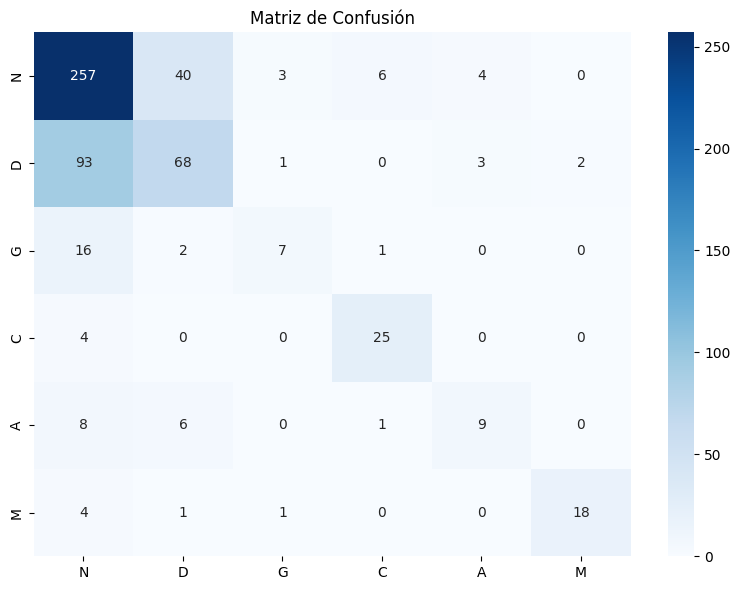

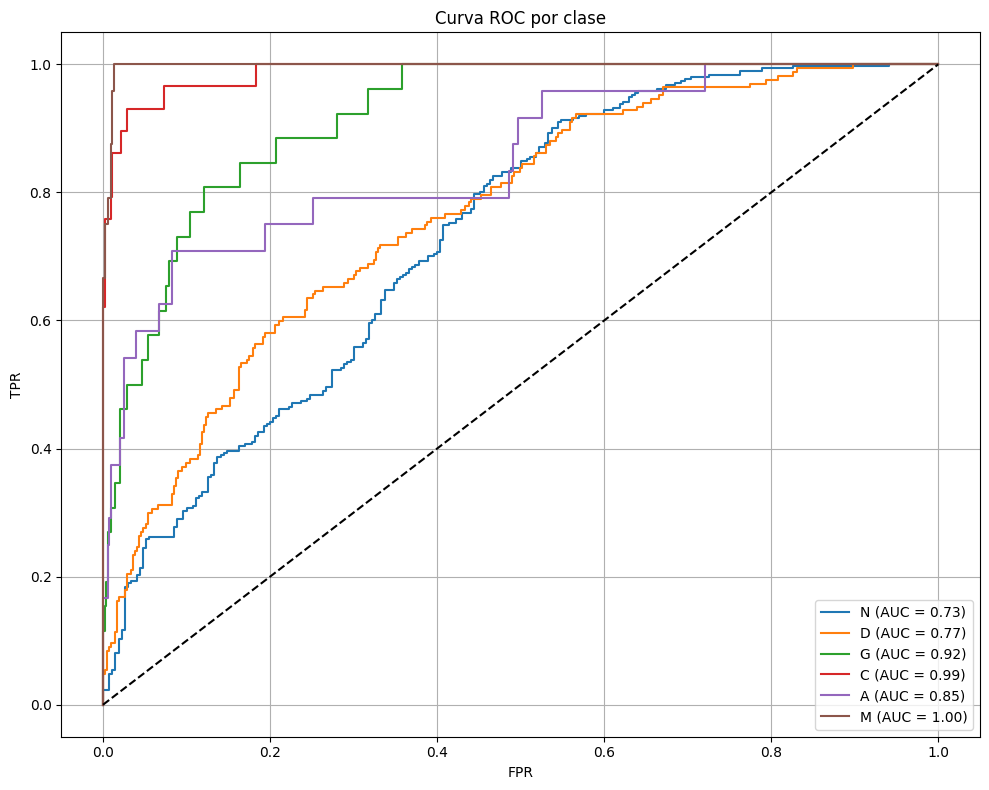

In [1]:
### Modelo 2 el mejor ###

import os, sys, cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
IMG_SIZE   = 224
BATCH_SIZE = 16
EPOCHS     = 80
LABELS     = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP  = {c: i for i, c in enumerate(LABELS)}
WEIGHTS_RF = r"C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth"

# PATH a modelo RETFound
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

# === Cargar CSVs y datos ===
train_df = pd.read_csv("C:/Users/34629/TFG/train_TT.csv")
val_df = pd.read_csv("C:/Users/34629/TFG/val_TT.csv")
train_df['label'] = train_df['class_label'].map(LABEL_MAP)
val_df['label'] = val_df['class_label'].map(LABEL_MAP)

train_paths = train_df['Image_Path'].tolist()
val_paths = val_df['Image_Path'].tolist()
y_tr = np.array(train_df['label'].tolist())
y_vl = np.array(val_df['label'].tolist())

# === Cargar RETFound extraído ===
X_rf_tr = np.load("C:/Users/34629/Downloads/X_TT_train.npy")
X_rf_vl = np.load("C:/Users/34629/Downloads/X_TT_val.npy")

# === Extraer EfficientNet solo si no existen ===
eff_train_path = "C:/Users/34629/Downloads/X_eff_TT_train.npy"
eff_val_path   = "C:/Users/34629/Downloads/X_eff_TT_val.npy"

def extract_efficientnet_features(image_paths):
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    feats = []
    for p in tqdm(image_paths, desc="EfficientNet"):
        img = cv2.resize(cv2.imread(p), (IMG_SIZE, IMG_SIZE))
        x = preprocess_input(img.astype('float32'))
        f = model.predict(np.expand_dims(x, 0), verbose=0).squeeze()
        feats.append(f)
    return np.stack(feats)

if os.path.exists(eff_train_path) and os.path.exists(eff_val_path):
    X_eff_tr = np.load(eff_train_path)
    X_eff_vl = np.load(eff_val_path)
else:
    X_eff_tr = extract_efficientnet_features(train_paths)
    np.save(eff_train_path, X_eff_tr)
    X_eff_vl = extract_efficientnet_features(val_paths)
    np.save(eff_val_path, X_eff_vl)

# === Concatenar features ===
X_tr = np.concatenate([X_rf_tr, X_eff_tr], axis=1)
X_vl = np.concatenate([X_rf_vl, X_eff_vl], axis=1)
y_tr_cat = tf.keras.utils.to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = tf.keras.utils.to_categorical(y_vl, num_classes=len(LABELS))

# === Modelo ===
inp = Input(shape=(X_tr.shape[1],))
x   = Dense(1024, activation='relu')(inp)
x   = Dropout(0.3)(x); x = BatchNormalization()(x)
x   = Dense(512, activation='relu')(x)
x   = Dropout(0.2)(x); x = BatchNormalization()(x)
x   = Dense(256, activation='relu')(x)
x   = Dropout(0.1)(x)
out = Dense(len(LABELS), activation='softmax')(x)
model = Model(inp, out)

model.compile(
    optimizer=Adam(1e-4),
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=False),
    metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro')]
)

model.fit(
    X_tr, y_tr_cat,
    validation_data=(X_vl, y_vl_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True),
        ModelCheckpoint("modelo2_tt_tradicional.h5", monitor='val_f1_score', mode='max', save_best_only=True)
    ],
    verbose=2
)

# === Evaluación ===
y_probs = model.predict(X_vl)
y_pred  = y_probs.argmax(axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_vl, y_pred, target_names=LABELS))

# === Matriz de confusión ===
cm = confusion_matrix(y_vl, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo2_TT_tradicional.png")
plt.show()

# === Curva ROC ===
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_vl, classes=range(len(LABELS)))

plt.figure(figsize=(10,8))
for i in range(len(LABELS)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{LABELS[i]} (AUC = {auc_score:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title("Curva ROC por clase")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("curva_ROC_modelo2_TT_tradicional.png")
plt.show()

# === Grad-CAM ===
from PIL import Image
from torchvision import transforms

sys.path.append("C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load(WEIGHTS_RF, map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(model, sd)
    model.load_state_dict(sd, strict=False)
    model.eval()

    activations = {}
    def hook_fn(module, input, output): activations['value'] = output
    model.blocks[11].register_forward_hook(hook_fn)

    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)

    with torch.no_grad(): out = model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14, 14)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * (cam - cam.min()) / (cam.max() - cam.min()))
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    cv2.imwrite(nombre_archivo, cv2.cvtColor(np.uint8(superpuesta), cv2.COLOR_RGB2BGR))

# Aplicar a una bien y una mal clasificada
df_res = pd.DataFrame({
    'img': val_paths,
    'real': [LABELS[i] for i in y_vl],
    'pred': [LABELS[i] for i in y_pred]
})
df_res['correct'] = df_res['real'] == df_res['pred']

bien = df_res[df_res['correct']].iloc[0]
mal = df_res[~df_res['correct']].iloc[0]

generar_gradcam(bien['img'], f"gradcam_modelo2_TT_correcto_{bien['pred']}.png")
generar_gradcam(mal['img'], f"gradcam_modelo2_TT_error_{mal['real']}_pred{mal['pred']}.png")


In [2]:
### Modelo 3 Mixup ###


import os, sys, cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from PIL import Image
from torchvision import transforms

# Config
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABELS = ['N', 'D', 'G', 'C', 'A', 'M']
LABEL_MAP = {c: i for i, c in enumerate(LABELS)}
ENSEMBLE_W = 0.7

# Cargar datos
X1_tr = np.load("C:/Users/34629/Downloads/X_TT_train.npy")
X2_tr = np.load("C:/Users/34629/Downloads/X_eff_TT_train.npy")
y_tr  = np.load("C:/Users/34629/Downloads/y_TT_train.npy")
X1_vl = np.load("C:/Users/34629/Downloads/X_TT_val.npy")
X2_vl = np.load("C:/Users/34629/Downloads/X_eff_TT_val.npy")
y_vl  = np.load("C:/Users/34629/Downloads/y_TT_val.npy")
paths_val = pd.read_csv("C:/Users/34629/TFG/val_TT.csv")["Image_Path"].tolist()

# One-hot encoding
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# Mixup
def mixup(x1, x2, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(x1))
    return lam * x1 + (1 - lam) * x1[idx], lam * x2 + (1 - lam) * x2[idx], lam * y + (1 - lam) * y[idx]

X1_tr, X2_tr, y_tr_cat = mixup(X1_tr, X2_tr, y_tr_cat)

# Modelos
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2)
y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

m1.fit(X1_tr, y_tr_cat, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
m2.fit(X2_tr, y_tr_cat, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Ensemble y umbrales
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2
THRESH = np.ones(len(LABELS)) * 0.5
y_true = y_vl
y_vl_bin = label_binarize(y_true, classes=list(range(len(LABELS))))

from sklearn.metrics import precision_recall_curve
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_true == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# Resultados
print(classification_report(y_true, y_pred, target_names=LABELS))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo_TT_mixup.png")
plt.close()

# ROC
plt.figure(figsize=(10, 7))
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_ROC_modelo_TT_mixup.png")
plt.close()

# Grad-CAM
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ret_model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None); sd.pop('head.bias', None)
    interpolate_pos_embed(ret_model, sd)
    ret_model.load_state_dict(sd, strict=False)
    ret_model.eval()

    activations = {}
    def hook_fn(module, input, output):
        activations['value'] = output
    ret_model.blocks[11].register_forward_hook(hook_fn)

    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad(): logits = ret_model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14,14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    superpuesta = np.uint8(superpuesta)
    cv2.imwrite(nombre_archivo, cv2.cvtColor(superpuesta, cv2.COLOR_RGB2BGR))

# Aplicar Grad-CAM
df_res = pd.DataFrame({
    'img': paths_val[:len(y_true)],
    'true': [LABELS[i] for i in y_true],
    'pred': [LABELS[i] for i in y_pred]
})
df_res['correcto'] = df_res['true'] == df_res['pred']

bien = df_res[df_res['correcto']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_TT_mixup_correcto_{bien['pred']}.png")

mal = df_res[~df_res['correcto']].iloc[0]
generar_gradcam(mal['img'], f"gradcam_TT_mixup_error_{mal['true']}_pred{mal['pred']}.png")


Epoch 1/80
762/762 - 86s - loss: 0.3273 - accuracy: 0.3293 - f1: 0.2873 - val_loss: 0.2088 - val_accuracy: 0.5741 - val_f1: 0.3722 - 86s/epoch - 112ms/step
Epoch 2/80
762/762 - 57s - loss: 0.2572 - accuracy: 0.3933 - f1: 0.3310 - val_loss: 0.1954 - val_accuracy: 0.5690 - val_f1: 0.4463 - 57s/epoch - 75ms/step
Epoch 3/80
762/762 - 59s - loss: 0.2417 - accuracy: 0.4271 - f1: 0.3505 - val_loss: 0.1939 - val_accuracy: 0.5845 - val_f1: 0.4157 - 59s/epoch - 78ms/step
Epoch 4/80
762/762 - 62s - loss: 0.2361 - accuracy: 0.4487 - f1: 0.3651 - val_loss: 0.1942 - val_accuracy: 0.5845 - val_f1: 0.4135 - 62s/epoch - 81ms/step
Epoch 5/80
762/762 - 57s - loss: 0.2322 - accuracy: 0.4586 - f1: 0.3719 - val_loss: 0.1983 - val_accuracy: 0.5793 - val_f1: 0.4512 - 57s/epoch - 74ms/step
Epoch 6/80
762/762 - 56s - loss: 0.2291 - accuracy: 0.4769 - f1: 0.3802 - val_loss: 0.1840 - val_accuracy: 0.5966 - val_f1: 0.4036 - 56s/epoch - 74ms/step
Epoch 7/80
762/762 - 57s - loss: 0.2273 - accuracy: 0.4844 - f1: 0.38

In [3]:
### Modelo 4 cutmix ###

import os, sys, cv2
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms

# Ajustes generales
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 80
LABELS = ['N','D','G','C','A','M']
LABEL_MAP = {c:i for i,c in enumerate(LABELS)}
ENSEMBLE_W = 0.7

# Carga de datos preextraídos
X1_tr = np.load("C:/Users/34629/Downloads/X_TT_train.npy")
X2_tr = np.load("C:/Users/34629/Downloads/X_eff_TT_train.npy")
y_tr  = np.load("C:/Users/34629/Downloads/y_TT_train.npy")
X1_vl = np.load("C:/Users/34629/Downloads/X_TT_val.npy")
X2_vl = np.load("C:/Users/34629/Downloads/X_eff_TT_val.npy")
y_vl  = np.load("C:/Users/34629/Downloads/y_TT_val.npy")
paths_val = pd.read_csv("C:/Users/34629/TFG/val_TT.csv")["Image_Path"].tolist()

# One-hot
y_tr_cat = to_categorical(y_tr, num_classes=len(LABELS))
y_vl_cat = to_categorical(y_vl, num_classes=len(LABELS))

# CutMix Generator individual
def cutmix_generator(X, y, batch_size, alpha=1.0):
    n = len(X)
    while True:
        idx = np.random.permutation(n)
        X_a, y_a = X[idx[:batch_size]], y[idx[:batch_size]]
        X_b, y_b = X[idx[batch_size:2*batch_size]], y[idx[batch_size:2*batch_size]]
        lam = np.random.beta(alpha, alpha)
        yield lam * X_a + (1 - lam) * X_b, lam * y_a + (1 - lam) * y_b

# Modelos
inp1 = Input((X1_tr.shape[1],))
x = Dense(1024)(inp1)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.1)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
out1 = Dense(len(LABELS), activation='softmax')(x)
m1 = Model(inp1, out1)

inp2 = Input((X2_tr.shape[1],))
y_ = Dense(512, activation='relu')(inp2)
y_ = Dropout(0.4)(y_)
out2 = Dense(len(LABELS), activation='softmax')(y_)
m2 = Model(inp2, out2)

# Compilación
loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False)
for model in [m1, m2]:
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_fn,
                  metrics=['accuracy', tfa.metrics.F1Score(num_classes=len(LABELS), average='macro', name='f1')])

cb_rf = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
         ModelCheckpoint("Clas_TT_rf_cutmix_manual.h5", monitor='val_f1', save_best_only=True)]
cb_eff = [EarlyStopping('val_f1', mode='max', patience=10, restore_best_weights=True),
          ModelCheckpoint("Clas_TT_eff_cutmix_manual.h5", monitor='val_f1', save_best_only=True)]

# Generadores separados
gen_rf  = cutmix_generator(X1_tr, y_tr_cat, BATCH_SIZE, alpha=1.0)
gen_eff = cutmix_generator(X2_tr, y_tr_cat, BATCH_SIZE, alpha=1.0)

# Entrenamiento
steps = len(X1_tr) // BATCH_SIZE
m1.fit(gen_rf, steps_per_epoch=steps, validation_data=(X1_vl, y_vl_cat), epochs=EPOCHS, callbacks=cb_rf, verbose=2)
m2.fit(gen_eff, steps_per_epoch=steps, validation_data=(X2_vl, y_vl_cat), epochs=EPOCHS, callbacks=cb_eff, verbose=2)

# Ensemble
p1 = m1.predict(X1_vl)
p2 = m2.predict(X2_vl)
probs = ENSEMBLE_W * p1 + (1 - ENSEMBLE_W) * p2

# Umbral
THRESH = np.ones(len(LABELS)) * 0.5
y_true = y_vl
y_vl_bin = label_binarize(y_true, classes=list(range(len(LABELS))))
for i in range(len(LABELS)):
    prec, rec, thr = precision_recall_curve((y_true == i).astype(int), probs[:, i])
    F = 2 * prec * rec / (prec + rec + 1e-8)
    THRESH[i] = thr[np.nanargmax(F)]

y_pred = []
for row in probs:
    sel = np.where(row >= THRESH)[0]
    if len(sel) == 1: y_pred.append(sel[0])
    elif len(sel) > 1: y_pred.append(sel[np.argmax(row[sel])])
    else: y_pred.append(int(np.argmax(row)))
y_pred = np.array(y_pred)

# Reporte
print(classification_report(y_true, y_pred, target_names=LABELS))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.savefig("matriz_confusion_modelo_TT_cutmix.png")
plt.close()

# ROC Curves
plt.figure(figsize=(10, 7))
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(y_vl_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_ROC_modelo_TT_cutmix.png")
plt.close()

# Grad-CAM
sys.path.append(r"C:/Users/34629/Downloads/RETFound_MAE")
from models_vit import RETFound_mae
from util.pos_embed import interpolate_pos_embed

def generar_gradcam(img_path, nombre_archivo):
    import argparse
    torch.serialization.add_safe_globals([argparse.Namespace])
    ret_model = RETFound_mae(global_pool=False, img_size=IMG_SIZE)
    ckpt = torch.load("C:/Users/34629/Downloads/RETFound_MAE/RETFound_cfp_weights.pth", map_location='cpu', weights_only=False)
    sd = ckpt['model']
    sd.pop('head.weight', None)
    sd.pop('head.bias', None)
    interpolate_pos_embed(ret_model, sd)
    ret_model.load_state_dict(sd, strict=False)
    ret_model.eval()

    activations = {}
    def hook_fn(module, input, output):
        activations['value'] = output
    ret_model.blocks[11].register_forward_hook(hook_fn)

    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    x = transforms.ToTensor()(img).unsqueeze(0)
    with torch.no_grad():
        logits = ret_model(x)
    cam = activations['value'].squeeze(0).numpy()[1:].mean(axis=1).reshape(14,14)
    cam = cv2.resize((cam - cam.min()) / (cam.max() - cam.min()), (IMG_SIZE, IMG_SIZE))
    cam = np.uint8(255 * cam)
    cam_color = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    superpuesta = 0.4 * np.array(img) + 0.6 * cam_color
    superpuesta = np.uint8(superpuesta)
    cv2.imwrite(nombre_archivo, cv2.cvtColor(superpuesta, cv2.COLOR_RGB2BGR))

# Evaluación visual
df_res = pd.DataFrame({
    'img': paths_val[:len(y_true)],
    'true': [LABELS[i] for i in y_true],
    'pred': [LABELS[i] for i in y_pred]
})
df_res['correcto'] = df_res['true'] == df_res['pred']

bien = df_res[df_res['correcto']].iloc[0]
generar_gradcam(bien['img'], f"gradcam_TT_cutmix_correcto_{bien['pred']}.png")

mal = df_res[~df_res['correcto']].iloc[0]
generar_gradcam(mal['img'], f"gradcam_TT_cutmix_error_{mal['true']}_pred{mal['pred']}.png")


Epoch 1/80


c:\Users\34629\TFG\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


761/761 - 54s - loss: 0.3390 - accuracy: 0.3626 - f1: 0.3252 - val_loss: 0.1891 - val_accuracy: 0.5690 - val_f1: 0.4537 - 54s/epoch - 72ms/step
Epoch 2/80
761/761 - 41s - loss: 0.2473 - accuracy: 0.4506 - f1: 0.3901 - val_loss: 0.2051 - val_accuracy: 0.5103 - val_f1: 0.5106 - 41s/epoch - 54ms/step
Epoch 3/80
761/761 - 41s - loss: 0.2284 - accuracy: 0.4740 - f1: 0.4116 - val_loss: 0.1868 - val_accuracy: 0.5793 - val_f1: 0.4307 - 41s/epoch - 53ms/step
Epoch 4/80
761/761 - 40s - loss: 0.2204 - accuracy: 0.4982 - f1: 0.4256 - val_loss: 0.1831 - val_accuracy: 0.5448 - val_f1: 0.4518 - 40s/epoch - 53ms/step
Epoch 5/80
761/761 - 39s - loss: 0.2147 - accuracy: 0.5124 - f1: 0.4373 - val_loss: 0.1744 - val_accuracy: 0.5983 - val_f1: 0.4415 - 39s/epoch - 51ms/step
Epoch 6/80
761/761 - 32s - loss: 0.2106 - accuracy: 0.5176 - f1: 0.4395 - val_loss: 0.1709 - val_accuracy: 0.6052 - val_f1: 0.4705 - 32s/epoch - 42ms/step
Epoch 7/80
761/761 - 33s - loss: 0.2090 - accuracy: 0.5267 - f1: 0.4487 - val_los

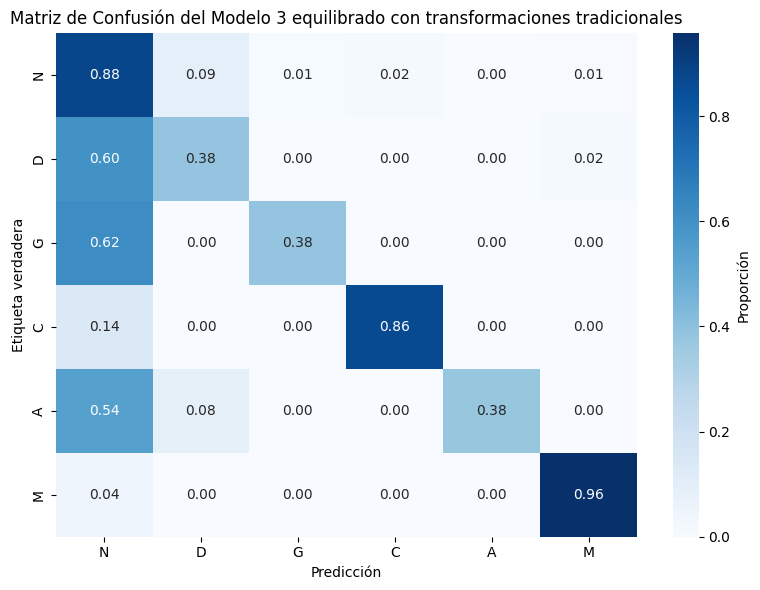

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz extraída visualmente de la imagen que has subido
conf_matrix = np.array([
    [272, 28,  3,  5, 0, 2],
    [100, 64, 0,  0, 0, 3],
    [16,  0, 10, 0, 0, 0],
    [4,   0,  0, 25, 0, 0],
    [13,  2,  0,  0, 9, 0],
    [1,   0,  0,  0, 0, 23],
])

labels = ['N', 'D', 'G', 'C', 'A', 'M']

# Normalización por filas (etiquetas reales)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_norm = conf_matrix / row_sums

# Representación
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proporción'})
plt.title("Matriz de Confusión del Modelo 3 equilibrado con transformaciones tradicionales")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.tight_layout()
plt.show()
